In [1]:
import openmc
import openmc.deplete

%matplotlib inline
import numpy as np

In [13]:
fuel = openmc.Material(name="uo2")
fuel.add_element("U", 1, percent_type="ao", enrichment=4.25)
fuel.add_element("O", 2)
fuel.set_density("g/cc", 10.4)

clad = openmc.Material(name='clad');
clad.add_element("Zr",1);
clad.set_density('g/cc',6.0);

water = openmc.Material(name='water');
water.add_element('O',1);
water.add_element('H',2)
water.set_density('g/cc',0.712); # high temperature density
water.add_s_alpha_beta('c_H_in_H2O');

materials = openmc.Materials([fuel,clad,water]);

In [14]:
h_core = 300.; 
h_fuel = 200.;

r_fuel = 0.42;
r_pin = 0.45;

P_D = 1.4;

pitch = P_D*2*r_pin;

fuel_temp = 900; # K, guess at fuel temperature
mod_temp = 600; # K, moderator temperature

# fuel cylinder:
fuel_cyl = openmc.model.RightCircularCylinder([0.,0.,-h_fuel/2.],
                                             h_fuel, r_fuel);

fuel.volume = np.pi*(r_fuel**2)*h_fuel;

# pin cylinder
pin_cyl = openmc.model.RightCircularCylinder([0.,0.,-(h_fuel+(r_pin-r_fuel))/2.],
                                            h_fuel+(r_pin-r_fuel)*2.,r_pin);

# pin cell container
core_cell = openmc.model.RectangularParallelepiped(-pitch/2.,pitch/2.,
                                                  -pitch/2.,pitch/2.,
                                                  -h_core/2.,h_core/2.,
                                                  boundary_type='reflective');

fuel_cell = openmc.Cell();
fuel_cell.region = -fuel_cyl
fuel_cell.fill = fuel;
fuel_cell.temperature = fuel_temp;


clad_cell = openmc.Cell();
clad_cell.region = +fuel_cyl & -pin_cyl;
clad_cell.fill = clad;

mod_cell = openmc.Cell();
mod_cell.region = +pin_cyl & -core_cell;
mod_cell.fill = water

root_univ = openmc.Universe();
root_univ.add_cells([fuel_cell,clad_cell,mod_cell]);

geometry = openmc.Geometry();
geometry.root_universe = root_univ;



materials.export_to_xml();
geometry.export_to_xml();



In [15]:
settings = openmc.Settings();
settings.run_mode = 'eigenvalue';
settings.particles = 10000;
settings.batches = 100;
settings.inactive = 25

box = openmc.stats.Box(lower_left = (-r_fuel,-r_fuel,-h_fuel/2.),
                      upper_right = (r_fuel,r_fuel,h_fuel/2.),
                      only_fissionable=True);
src = openmc.Source(space=box);

settings.source = src;

settings.temperature['method']='interpolation';

settings.export_to_xml();

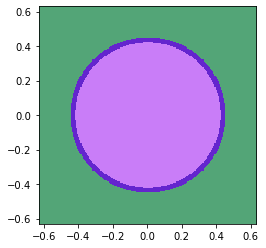

In [16]:
root_univ.plot(width=(pitch,pitch));

In [17]:
openmc.run();

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

note for cold begining of life, $k_{\text{eff}} = 1.45998 \pm 0.00154$.

for hot beginning of life, $k_{\text{eff}} = 1.37613 \pm 0.00153$.

In [18]:
operator = openmc.deplete.Operator(geometry,settings,"chain_casl_pwr.xml");

power = 1e4;
days = 24*3600;
time_steps = [0.1*days,0.1*days,0.3*days,0.5*days,1.*days,30.*days,30.*days,100.*days, 360.*days, 360.*days, 360.*days,360.*days,720.*days,720.*days];
integrator = openmc.deplete.PredictorIntegrator(operator,time_steps,power=power);

In [19]:
integrator.integrate()

In [20]:
results = openmc.deplete.ResultsList.from_hdf5('./depletion_results.h5')

In [21]:
time,k = results.get_eigenvalue()
time /= (24*60*60);

In [22]:
from matplotlib import pyplot

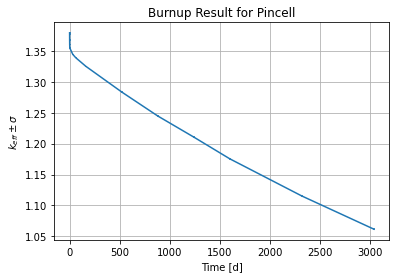

In [23]:
pyplot.errorbar(time,k[:,0],yerr=k[:,1]);
pyplot.title('Burnup Result for Pincell')
pyplot.xlabel('Time [d]');
pyplot.ylabel('$k_{eff} \pm \sigma$');
pyplot.grid()